In [1]:
#Libraries to handle data
import numpy as np
import pandas as pd

#Libraries to visualize
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for spliting data
from sklearn.model_selection import train_test_split, StratifiedKFold

#Libraries for Processing data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from category_encoders import OneHotEncoder, CatBoostEncoder

#Libraries for modeling
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Libraries for scoring
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay,roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
train = pd.read_csv('data/train.csv', index_col='id')
train.info()

test = pd.read_csv('data/test.csv',index_col='id')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [3]:
train.sample(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
31474,15783083,Shubin,534,France,Male,27.0,6,0.00,2,0.0,0.0,161344.13,0
86875,15701885,Tucker,687,Spain,Female,40.0,5,0.00,3,1.0,0.0,92357.21,1
682,15573076,Galkin,726,France,Female,40.0,5,0.00,2,1.0,1.0,50485.70,0
5091,15808582,Maclean,669,France,Female,40.0,6,0.00,1,1.0,1.0,172832.90,0
7611,15793724,Onwuatuegwu,653,Germany,Female,29.0,9,106511.85,1,0.0,1.0,181499.77,0


### EDA

Initial Analysis

In [4]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc['min'] = train.min()
desc['max'] = train.max()
desc

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4
HasCrCard,float64,165034,2,0.001212,0,0.0,0.0,1.0


Univariate Analysis

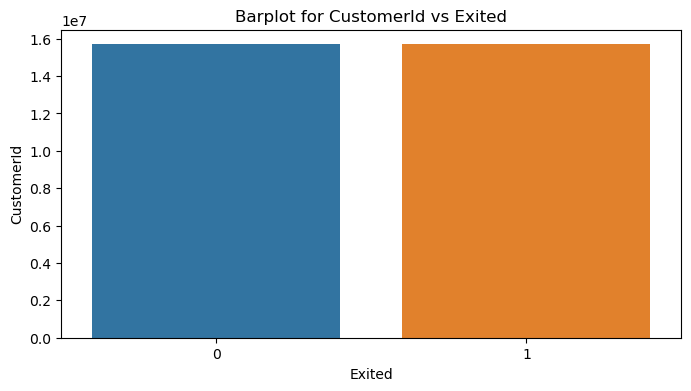

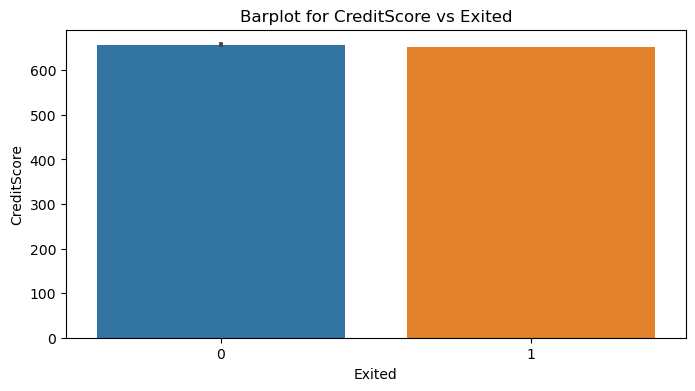

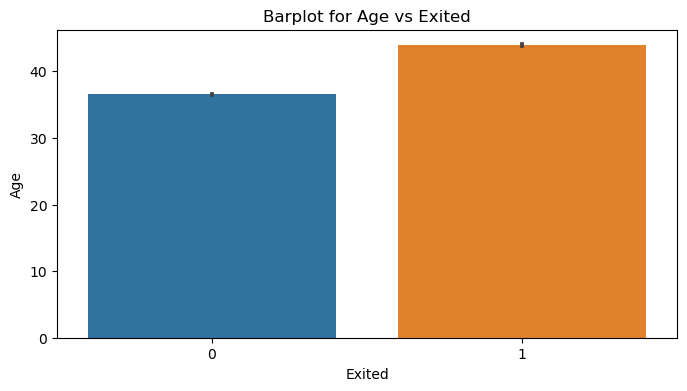

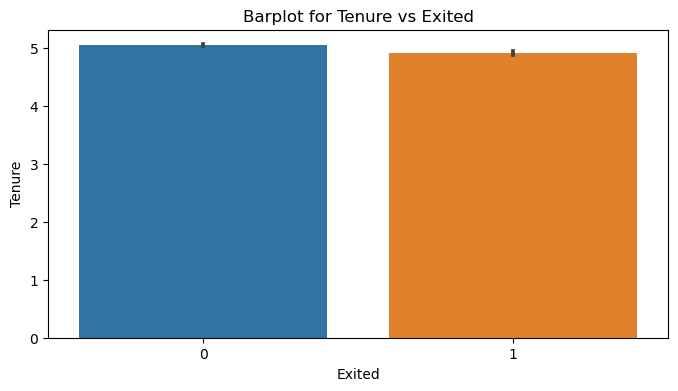

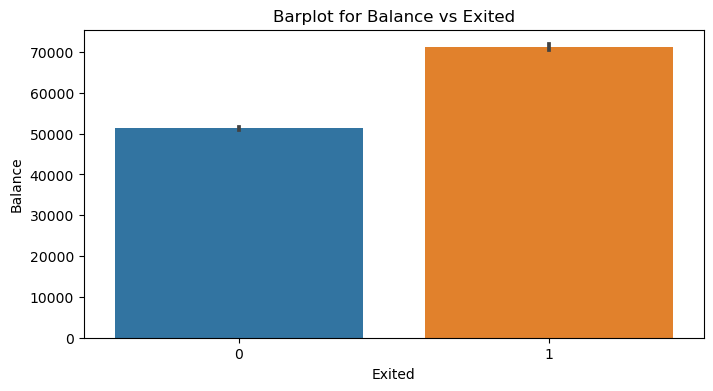

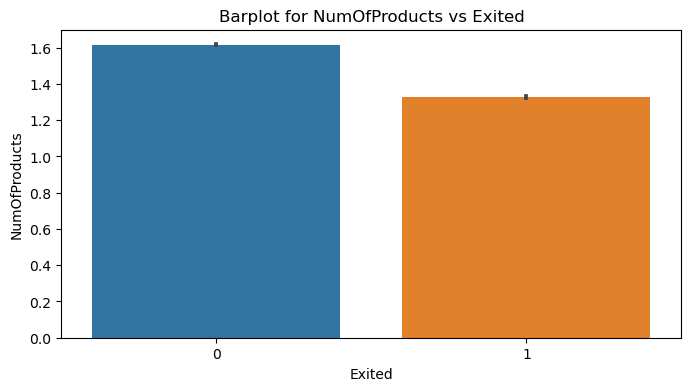

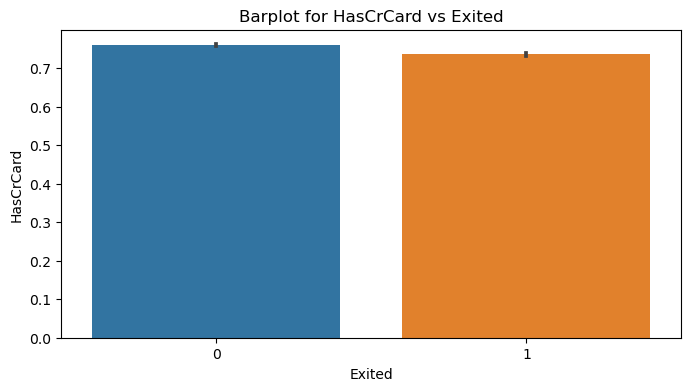

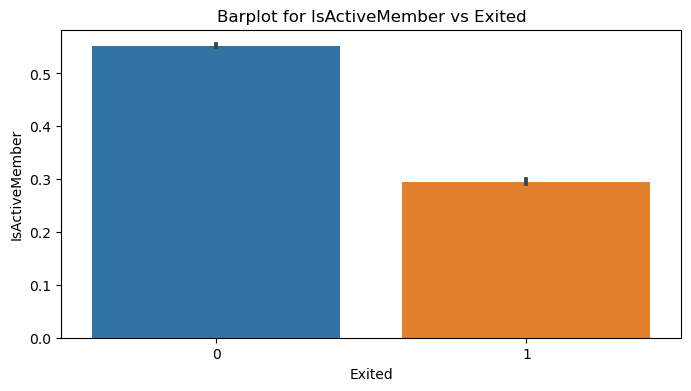

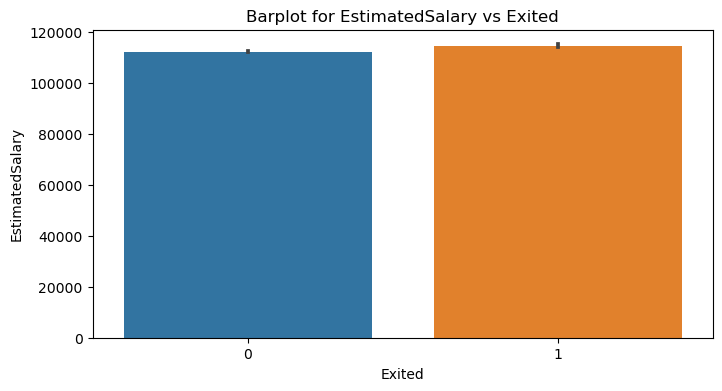

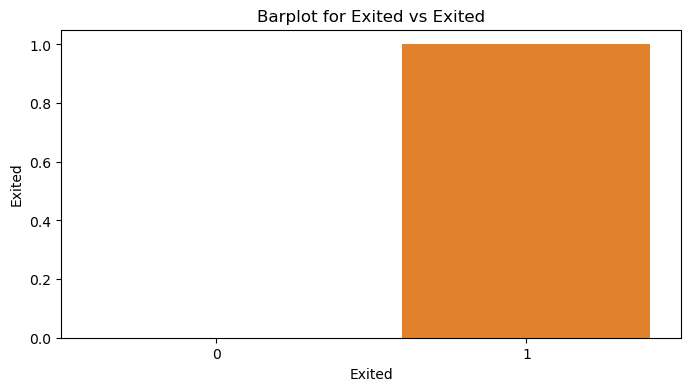

In [5]:
numeric_columns = train.select_dtypes(include=['number'])

# Set up individual plots
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(y=col, x="Exited", data=train)
    plt.title(f'Barplot for {col} vs Exited')
    plt.xlabel('Exited')
    plt.ylabel(col)
    plt.show()


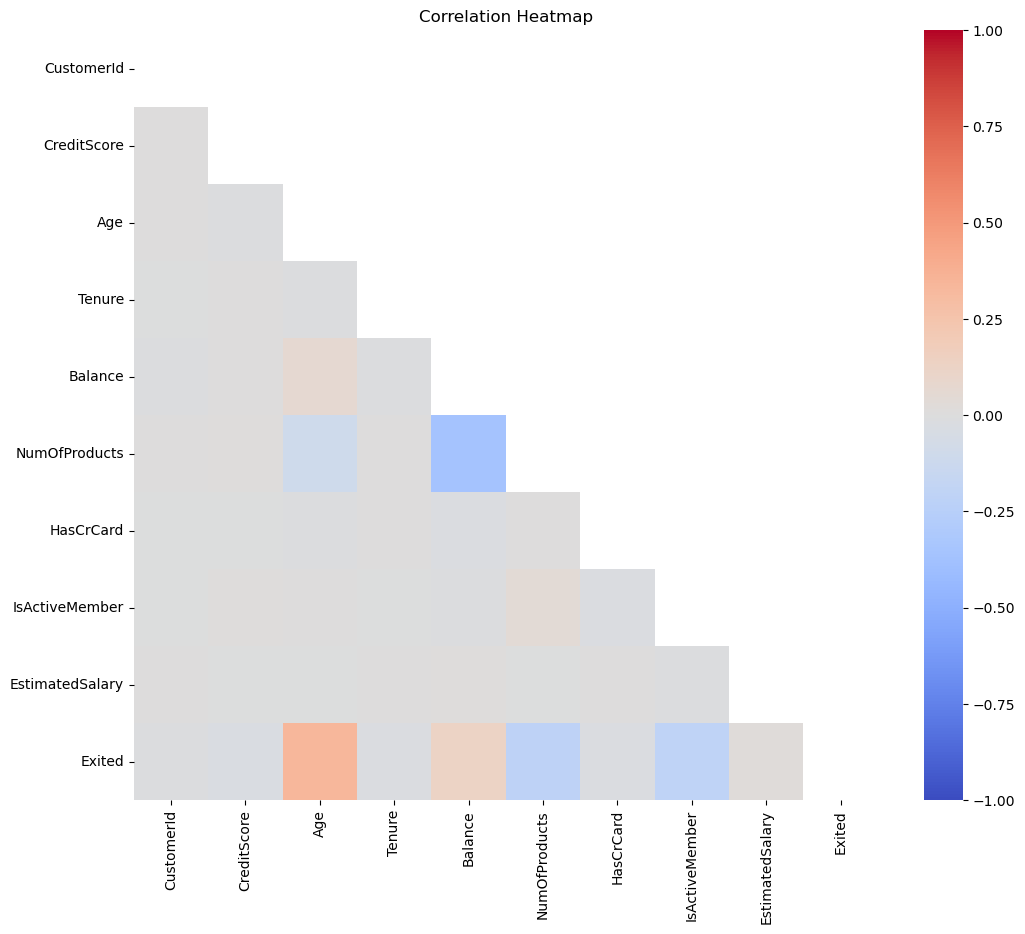

In [6]:
#Checking for correlation to drop correlating variables if necessary
corr_df = train.corr(numeric_only=True)
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap='coolwarm', fmt='.2f', vmin=-1.0, vmax=1.0,mask=mask_ut)
plt.title('Correlation Heatmap')
plt.show()

Bivariate analysis

In [7]:
Country_data = train.groupby('Geography').sum()

/tmp/ipykernel_5930/2544608375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Country_data = train.groupby('Geography').sum()


In [8]:
Country_data['Exited']

Geography
France     15572
Germany    13114
Spain       6235
Name: Exited, dtype: int64

In [9]:
Gender_data = train.groupby('Gender').sum()

/tmp/ipykernel_5930/2148721.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Gender_data = train.groupby('Gender').sum()


In [10]:
Gender_data['Exited']

Gender
Female    20105
Male      14816
Name: Exited, dtype: int64

### Data Preparation

In [11]:
X, y = train.drop("Exited", axis=1), train.Exited
skf = StratifiedKFold(n_splits=30, random_state=42, shuffle=True)

### Feature Engeneering

In [12]:
def FeatureEngineering(df):

    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    return df

In [13]:
Feature_Engineering = FunctionTransformer(FeatureEngineering)

In [19]:
# Identify categorical features 
is_cat = (X.dtypes != float)

# Get indices of categorical features
cat_features_index = np.where(is_cat)[0]

### Preprocessing

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CatBoostEncoder(),cat_features_index),
        ('num', StandardScaler(),np.where(X.dtypes == float)[0])
    ],
    remainder='passthrough'
)

### Modeling

In [37]:
Log = Pipeline([
    ('feats',Feature_Engineering),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [38]:
Log.fit(X_train,y_train)

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function FeatureEngineering at 0x7fb7fe0c9bd0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CatBoostEncoder(),
                                                  array([ 0,  1,  2,  3,  4,  6,  8, 12, 15, 16])),
                                                 ('num', StandardScaler(),
                                                  array([ 5,  7,  9, 10, 11, 13, 14]))])),
                ('classifier', LogisticRegression())])

In [39]:
y_proba = Log.predict(X_train)

In [40]:
Log.score(X_train,y_train)

0.788399342558719

In [41]:
CBC = Pipeline([
    ('feats',Feature_Engineering),
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])

In [42]:
CBC.fit(X_train,y_train)

Learning rate set to 0.082881
0:	learn: 0.6177493	total: 16.4ms	remaining: 16.4s
1:	learn: 0.5574214	total: 32.5ms	remaining: 16.2s
2:	learn: 0.5115671	total: 51.7ms	remaining: 17.2s
3:	learn: 0.4756704	total: 70.4ms	remaining: 17.5s
4:	learn: 0.4470241	total: 87ms	remaining: 17.3s
5:	learn: 0.4252799	total: 104ms	remaining: 17.3s
6:	learn: 0.4073176	total: 120ms	remaining: 17.1s
7:	learn: 0.3929875	total: 137ms	remaining: 17s
8:	learn: 0.3817929	total: 150ms	remaining: 16.5s
9:	learn: 0.3728685	total: 168ms	remaining: 16.6s
10:	learn: 0.3648780	total: 185ms	remaining: 16.6s
11:	learn: 0.3585662	total: 204ms	remaining: 16.8s
12:	learn: 0.3546645	total: 222ms	remaining: 16.8s
13:	learn: 0.3505237	total: 234ms	remaining: 16.5s
14:	learn: 0.3464332	total: 251ms	remaining: 16.5s
15:	learn: 0.3435542	total: 270ms	remaining: 16.6s
16:	learn: 0.3404677	total: 288ms	remaining: 16.6s
17:	learn: 0.3379724	total: 304ms	remaining: 16.6s
18:	learn: 0.3359191	total: 323ms	remaining: 16.7s
19:	learn:

163:	learn: 0.3094339	total: 2.71s	remaining: 13.8s
164:	learn: 0.3093675	total: 2.73s	remaining: 13.8s
165:	learn: 0.3093019	total: 2.75s	remaining: 13.8s
166:	learn: 0.3092359	total: 2.77s	remaining: 13.8s
167:	learn: 0.3091785	total: 2.79s	remaining: 13.8s
168:	learn: 0.3091088	total: 2.81s	remaining: 13.8s
169:	learn: 0.3090417	total: 2.82s	remaining: 13.8s
170:	learn: 0.3089921	total: 2.84s	remaining: 13.8s
171:	learn: 0.3089089	total: 2.85s	remaining: 13.7s
172:	learn: 0.3088541	total: 2.87s	remaining: 13.7s
173:	learn: 0.3087903	total: 2.89s	remaining: 13.7s
174:	learn: 0.3087252	total: 2.9s	remaining: 13.7s
175:	learn: 0.3086647	total: 2.92s	remaining: 13.7s
176:	learn: 0.3086146	total: 2.94s	remaining: 13.7s
177:	learn: 0.3085600	total: 2.96s	remaining: 13.7s
178:	learn: 0.3084981	total: 2.97s	remaining: 13.6s
179:	learn: 0.3084246	total: 2.99s	remaining: 13.6s
180:	learn: 0.3083640	total: 3s	remaining: 13.6s
181:	learn: 0.3082922	total: 3.02s	remaining: 13.6s
182:	learn: 0.30

330:	learn: 0.3006044	total: 5.71s	remaining: 11.5s
331:	learn: 0.3005581	total: 5.73s	remaining: 11.5s
332:	learn: 0.3005176	total: 5.77s	remaining: 11.5s
333:	learn: 0.3004660	total: 5.78s	remaining: 11.5s
334:	learn: 0.3004186	total: 5.8s	remaining: 11.5s
335:	learn: 0.3003908	total: 5.82s	remaining: 11.5s
336:	learn: 0.3003295	total: 5.84s	remaining: 11.5s
337:	learn: 0.3002823	total: 5.85s	remaining: 11.5s
338:	learn: 0.3002553	total: 5.87s	remaining: 11.4s
339:	learn: 0.3002120	total: 5.88s	remaining: 11.4s
340:	learn: 0.3001687	total: 5.9s	remaining: 11.4s
341:	learn: 0.3001289	total: 5.92s	remaining: 11.4s
342:	learn: 0.3000894	total: 5.93s	remaining: 11.4s
343:	learn: 0.3000516	total: 5.95s	remaining: 11.3s
344:	learn: 0.3000177	total: 5.96s	remaining: 11.3s
345:	learn: 0.2999558	total: 5.98s	remaining: 11.3s
346:	learn: 0.2999030	total: 6s	remaining: 11.3s
347:	learn: 0.2998682	total: 6.01s	remaining: 11.3s
348:	learn: 0.2998121	total: 6.03s	remaining: 11.2s
349:	learn: 0.299

491:	learn: 0.2938504	total: 9.02s	remaining: 9.31s
492:	learn: 0.2938011	total: 9.04s	remaining: 9.29s
493:	learn: 0.2937418	total: 9.08s	remaining: 9.3s
494:	learn: 0.2937047	total: 9.11s	remaining: 9.29s
495:	learn: 0.2936551	total: 9.14s	remaining: 9.29s
496:	learn: 0.2935973	total: 9.17s	remaining: 9.28s
497:	learn: 0.2935581	total: 9.2s	remaining: 9.27s
498:	learn: 0.2935131	total: 9.24s	remaining: 9.27s
499:	learn: 0.2934826	total: 9.26s	remaining: 9.26s
500:	learn: 0.2934355	total: 9.29s	remaining: 9.25s
501:	learn: 0.2933988	total: 9.32s	remaining: 9.24s
502:	learn: 0.2933600	total: 9.35s	remaining: 9.23s
503:	learn: 0.2933151	total: 9.37s	remaining: 9.22s
504:	learn: 0.2932884	total: 9.4s	remaining: 9.21s
505:	learn: 0.2932535	total: 9.43s	remaining: 9.2s
506:	learn: 0.2932124	total: 9.46s	remaining: 9.2s
507:	learn: 0.2931819	total: 9.48s	remaining: 9.18s
508:	learn: 0.2931553	total: 9.5s	remaining: 9.16s
509:	learn: 0.2931101	total: 9.53s	remaining: 9.15s
510:	learn: 0.2930

651:	learn: 0.2877462	total: 12.1s	remaining: 6.47s
652:	learn: 0.2877172	total: 12.1s	remaining: 6.45s
653:	learn: 0.2876786	total: 12.2s	remaining: 6.43s
654:	learn: 0.2876297	total: 12.2s	remaining: 6.41s
655:	learn: 0.2875959	total: 12.2s	remaining: 6.39s
656:	learn: 0.2875547	total: 12.2s	remaining: 6.37s
657:	learn: 0.2875170	total: 12.2s	remaining: 6.35s
658:	learn: 0.2874845	total: 12.2s	remaining: 6.33s
659:	learn: 0.2874523	total: 12.3s	remaining: 6.31s
660:	learn: 0.2874242	total: 12.3s	remaining: 6.29s
661:	learn: 0.2873844	total: 12.3s	remaining: 6.28s
662:	learn: 0.2873454	total: 12.3s	remaining: 6.26s
663:	learn: 0.2873082	total: 12.3s	remaining: 6.24s
664:	learn: 0.2872723	total: 12.4s	remaining: 6.22s
665:	learn: 0.2872339	total: 12.4s	remaining: 6.22s
666:	learn: 0.2872035	total: 12.4s	remaining: 6.2s
667:	learn: 0.2871724	total: 12.4s	remaining: 6.19s
668:	learn: 0.2871361	total: 12.5s	remaining: 6.17s
669:	learn: 0.2870802	total: 12.5s	remaining: 6.15s
670:	learn: 0

817:	learn: 0.2819742	total: 15.3s	remaining: 3.4s
818:	learn: 0.2819448	total: 15.3s	remaining: 3.38s
819:	learn: 0.2819143	total: 15.3s	remaining: 3.37s
820:	learn: 0.2818792	total: 15.3s	remaining: 3.35s
821:	learn: 0.2818471	total: 15.4s	remaining: 3.33s
822:	learn: 0.2818270	total: 15.4s	remaining: 3.31s
823:	learn: 0.2817892	total: 15.4s	remaining: 3.29s
824:	learn: 0.2817489	total: 15.4s	remaining: 3.27s
825:	learn: 0.2817142	total: 15.4s	remaining: 3.25s
826:	learn: 0.2816863	total: 15.4s	remaining: 3.23s
827:	learn: 0.2816565	total: 15.5s	remaining: 3.21s
828:	learn: 0.2816276	total: 15.5s	remaining: 3.19s
829:	learn: 0.2815867	total: 15.5s	remaining: 3.17s
830:	learn: 0.2815623	total: 15.5s	remaining: 3.15s
831:	learn: 0.2815386	total: 15.5s	remaining: 3.14s
832:	learn: 0.2814973	total: 15.6s	remaining: 3.12s
833:	learn: 0.2814549	total: 15.6s	remaining: 3.1s
834:	learn: 0.2814219	total: 15.6s	remaining: 3.08s
835:	learn: 0.2813846	total: 15.6s	remaining: 3.07s
836:	learn: 0.

977:	learn: 0.2766776	total: 18.1s	remaining: 407ms
978:	learn: 0.2766545	total: 18.1s	remaining: 388ms
979:	learn: 0.2766211	total: 18.1s	remaining: 370ms
980:	learn: 0.2765805	total: 18.1s	remaining: 351ms
981:	learn: 0.2765374	total: 18.2s	remaining: 333ms
982:	learn: 0.2765121	total: 18.2s	remaining: 314ms
983:	learn: 0.2764746	total: 18.2s	remaining: 296ms
984:	learn: 0.2764440	total: 18.2s	remaining: 277ms
985:	learn: 0.2764091	total: 18.2s	remaining: 259ms
986:	learn: 0.2763785	total: 18.2s	remaining: 240ms
987:	learn: 0.2763411	total: 18.3s	remaining: 222ms
988:	learn: 0.2763085	total: 18.3s	remaining: 203ms
989:	learn: 0.2762813	total: 18.3s	remaining: 185ms
990:	learn: 0.2762440	total: 18.3s	remaining: 166ms
991:	learn: 0.2762020	total: 18.3s	remaining: 148ms
992:	learn: 0.2761671	total: 18.3s	remaining: 129ms
993:	learn: 0.2761401	total: 18.3s	remaining: 111ms
994:	learn: 0.2761132	total: 18.4s	remaining: 92.3ms
995:	learn: 0.2760719	total: 18.4s	remaining: 73.8ms
996:	learn

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function FeatureEngineering at 0x7fb7fe0c9bd0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CatBoostEncoder(),
                                                  array([ 0,  1,  2,  3,  4,  6,  8, 12, 15, 16])),
                                                 ('num', StandardScaler(),
                                                  array([ 5,  7,  9, 10, 11, 13, 14]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fb7f7d78b50>)])

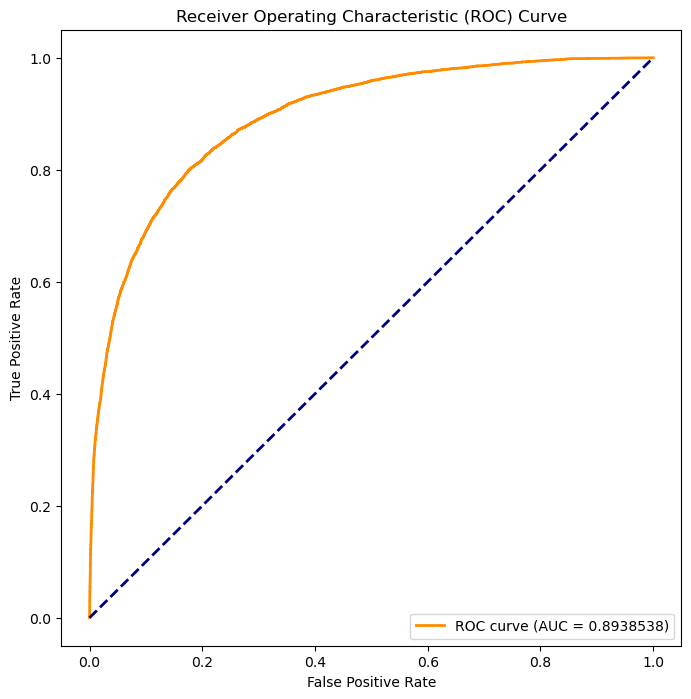

In [43]:
# Make predictions on the test set
y_pred_prob = CBC.predict_proba(X_test)[:,1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.7f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [33]:
y_pred = CBC.predict(X_test)
result = classification_report(y_test,y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.74      0.58      0.65      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007



In [45]:
preprocessor.named_transformers_

{'text': CatBoostEncoder(cols=['Surname', 'Geography', 'Gender', 'AgeCat',
                       'Sur_Geo_Gend_Sal']),
 'num': StandardScaler()}